
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./sen_shear.ipynb" download="sen_shear.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=sen_shear.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/PhaseField/PForthotropy_jupyter_notebook/sen_shear.py"><img src="https://img.shields.io/static/v1?label=Source:&message=sen_shear.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/PhaseField/PForthotropy_jupyter_notebook/sen_shear.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>


## Problem description

In order to verify the anisotropic phase field model detailed in (Ziaei-Rad et al., 2022), we present a single edge notched shear test specifically designed for materials with anisotropic/orthotropic behavior in the phase field approach to fracture to account for the tension–compression asymmetry. We generalize two existing models for tension-compression asymmetry in isotropic materials, namely the *volumetric-deviatoric* (Amor et al., 2009) and *no-tension* model (Freddi and Royer-Carfagni, 2010), towards materials with anisotropic nature.

The geometry and boundary conditions for this example is shown in the following Figure.

We consider a square plate with an initial horizontal crack placed at the middle height from the left outer surface to the center of the specimen. Plane strain condition was assumed for sake of less computational costs. The user is free to choose either $\texttt{AT}_1$ or $\texttt{AT}_2$ as for the phase field model.

The boundary conditions are as follows. The displacement along any direction on the bottom edge ($y=-L/2$) was fixed to zero. Also, the displacement at the top edge ($y = L/2$) was prescribed along the $x$-direction, where the $y$-direction was taken to be zero.

<img src="figures/shear_model.png" width="60%">

## Two helper functions

In [1]:
import os
import shutil
import time
from pathlib import Path
from subprocess import run
from types import MethodType
from xml.dom import minidom

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv

In [2]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

output_dir = out_dir

# define a method to replace a specific curve (analogue to replace_parameter method)


def replace_curve(
    self,
    name=None,
    value=None,
    coords=None,
    parametertype=None,
    valuetag="values",
    coordstag="coords",
):
    root = self._get_root()
    parameterpath = "./curves/curve"
    parameterpointer = self._get_parameter_pointer(root, name, parameterpath)
    self._set_type_value(parameterpointer, value, parametertype, valuetag=valuetag)
    self._set_type_value(parameterpointer, coords, parametertype, valuetag=coordstag)


# define a method to change timstepping in project file


def set_timestepping(model, repeat_list, delta_t_list):
    model.remove_element(
        xpath="./time_loop/processes/process/time_stepping/timesteps/pair"
    )
    for i in range(len(repeat_list)):
        model.add_block(
            blocktag="pair",
            parent_xpath="./time_loop/processes/process/time_stepping/timesteps",
            taglist=["repeat", "delta_t"],
            textlist=[repeat_list[i], delta_t_list[i]],
        )

## Run ogs with specified parameters

In [3]:
def ogs_ortho(
    phasefield_model,
    energy_split_model,
    length_scale=1.0,
    bc_displacement=1.0,
    ts_coords="0 1.0",
    values="0 1.0",
    repeat_list=None,
    delta_t_list=None,
    hypre=True,
    MPI=True,
    ncores=4,
):
    without_hypre = "-ksp_type cg -pc_type bjacobi -ksp_atol 1e-14 -ksp_rtol 1e-14"
    with_hypre = "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_strong_threshold 0.7 -ksp_atol 1e-8 -ksp_rtol 1e-8"

    prj_name = "shear.prj"
    print(
        f"> Running single edge notched shear test {phasefield_model} - {energy_split_model} ... <"
    )
    # fmt: off
    logfile = f"{out_dir}/log_{phasefield_model}_{energy_split_model}_out.txt"
    # fmt: on
    model = ot.Project(
        input_file=prj_name, output_file=f"{out_dir}/{prj_name}", MKL=True
    )

    # generate prefix from properties
    prefix = f"{phasefield_model}" + f"_{energy_split_model}"

    if MPI:
        # partition mesh
        run(
            f"NodeReordering -i shear.vtu -o {out_dir}/shear.vtu >> {logfile}",
            shell=True,
            check=True,
        )
        run(
            f"constructMeshesFromGeometry -m {out_dir}/shear.vtu -g shear.gml >> {logfile}",
            shell=True,
            check=True,
        )
        shutil.move("shear_top.vtu", f"{out_dir}/shear_top.vtu")
        shutil.move("shear_bottom.vtu", f"{out_dir}/shear_bottom.vtu")
        shutil.move("shear_left.vtu", f"{out_dir}/shear_left.vtu")
        shutil.move("shear_right.vtu", f"{out_dir}/shear_right.vtu")

        shutil.move("shear_p_0.vtu", f"{out_dir}/shear_p_0.vtu")
        shutil.move("shear_p_1.vtu", f"{out_dir}/shear_p_1.vtu")
        shutil.move("shear_p_2.vtu", f"{out_dir}/shear_p_2.vtu")
        shutil.move("shear_p_3.vtu", f"{out_dir}/shear_p_3.vtu")

        run(
            f"partmesh -s -o {out_dir} -i {out_dir}/shear.vtu >> {logfile}",
            shell=True,
            check=True,
        )
        run(
            f"partmesh -m -n {ncores} -o {out_dir} -i {out_dir}/shear.vtu -- {out_dir}/shear_top.vtu {out_dir}/shear_bottom.vtu {out_dir}/shear_left.vtu {out_dir}/shear_right.vtu >> {logfile}",
            shell=True,
            check=True,
        )
    else:
        run(
            f"NodeReordering -i shear.vtu -o {out_dir}/shear.vtu >> {logfile}",
            shell=True,
            check=True,
        )

    # change some properties in prj file
    model = ot.Project(
        input_file=prj_name, output_file=f"{out_dir}/{prj_name}", MKL=True
    )
    model.replace_parameter_value(name="ls", value=length_scale)
    model.replace_text(phasefield_model, xpath="./processes/process/phasefield_model")
    model.replace_text(
        energy_split_model, xpath="./processes/process/energy_split_model"
    )
    model.replace_text(prefix, xpath="./time_loop/output/prefix")

    model.replace_parameter_value(name="dirichlet_top", value=bc_displacement)
    model.replace_curve = MethodType(replace_curve, model)
    model.replace_curve(name="dirichlet_time", value=values, coords=ts_coords)

    if repeat_list is not None and delta_t_list is not None:
        set_timestepping(model, repeat_list, delta_t_list)
    else:
        set_timestepping(model, ["1"], ["1e-2"])
    if hypre is True:
        model.replace_text(
            with_hypre,
            xpath="./linear_solvers/linear_solver/petsc/parameters",
            occurrence=1,
        )
    else:
        model.replace_text(
            without_hypre,
            xpath="./linear_solvers/linear_solver/petsc/parameters",
            occurrence=1,
        )
    model.replace_text(Path("./shear.gml").resolve(), xpath="./geometry")
    model.write_input()
    # run ogs
    t0 = time.time()
    if MPI:
        print(f"  > OGS started execution with MPI - {ncores} cores...")
        run(
            f"mpirun --bind-to none -np {ncores} ogs {out_dir}/{prj_name} -o {output_dir} >> {logfile}",
            shell=True,
            check=True,
        )
    else:
        print("  > OGS started execution - ")
        run(
            f"ogs {out_dir}/{prj_name} -o {output_dir} >> {logfile}",
            shell=True,
            check=True,
        )
    tf = time.time()
    print("  > OGS terminated execution. Elapsed time: ", round(tf - t0, 2), " s.")

## Input data

We used the parameters of Opalinus Clay listed in the following Table. Note that the critical surface energy $G_c$ was taken to be independent of the material orientation.

| **Name**                       | **Value**          | **Unit**     | **Symbol** |
|--------------------------------|--------------------|--------------|------------|
| _Young's modulus_              | 6000               | MPa          | $E_1$      |
| _Young's modulus_              | 13800              | MPa          | $E_2$      |
| _Young's modulus_              | 13800              | MPa          | $E_3$      |
| _Poisson's ratio_              | 0.22               | $-$          | $v_{12}$   |
| _Poisson's ratio_              | 0.44               | $-$          | $v_{23}$   |
| _Poisson's ratio_              | 0.22               | $-$          | $v_{13}$   |
| _Shear modulus_                | 3200               | MPa          | $G_{12}$   |
| _Shear modulus_                | 1600               | MPa          | $G_{23}$   |
| _Shear modulus_                | 3200               | MPa          | $G_{13}$   |
| _Critical energy release rate_ | 0.5                | N/m          | $G_{c}$    |
| _Regularization parameter_     | 0.1                | mm           | $\ell$     |


## Run Simulations
> In the following, we used a coarse mesh and also coarse time stepping only for sake of less computational costs. The user is free to apply finer mesh and time stepping.

In [4]:
# Alternative parameters
# phasefield_model = ['AT1', 'AT2']
# energy_split_model = ['OrthoVolDev', 'OrthoMasonry']

disp = 1.0e-6  # to change the intensity of the shear loading applied on the top edge
ls = 1.0e-4  # regularization parameter to capture the convergence, though some references consider it as a material parameter (ls/h=4, h=2.5e-5)

mpi_cores = 4  # MPI cores
## Here we only run one selected case. Based on the user's local device, more/less cores can be added to speed up/save resources.

# With the AT2 model, we are verifying two different anisotropic models, namely, orthotropic volumetric-deviatoric and orthotropic no-tension:
# For more details of each model, please see the reference of Ziaei Rad et al., 2022.
for b in ["OrthoMasonry", "OrthoVolDev"]:
    ogs_ortho(
        "AT2",
        b,
        length_scale=ls,
        bc_displacement=disp,
        repeat_list=["1"],
        delta_t_list=["1.e-2"],
        ncores=mpi_cores,
    )

> Running single edge notched shear test AT2 - OrthoMasonry ... <


  > OGS started execution with MPI - 4 cores...


  > OGS terminated execution. Elapsed time:  118.11  s.
> Running single edge notched shear test AT2 - OrthoVolDev ... <


  > OGS started execution with MPI - 4 cores...


  > OGS terminated execution. Elapsed time:  66.17  s.


## Results

In the following, the crack paths are shown for orthotropic volumetric--deviatoric and {no-tension} models under the shear loading with material orientation angle ($\alpha=0$). The user is free to change $\alpha$ to her desired angle in the prj file.

An implementation of the presented anisotropic phase-field formulation combined with the unsaturated HM approach is also underway.

## Animation of crack propagation
The following film shows the crack propagation under the shear loading for no-tension model.

In [5]:
reader = pv.get_reader(f"{out_dir}/AT2_OrthoMasonry.pvd")

plotter = pv.Plotter()

plotter.open_gif(f"{out_dir}/AT2_OrthoMasonry.gif")
pv.set_plot_theme("document")
for time_value in reader.time_values:
    reader.set_active_time_value(time_value)
    mesh = reader.read()[0]  # This dataset only has 1 block

    sargs = {
        "title": "Phase field",
        "title_font_size": 20,
        "label_font_size": 15,
        "n_labels": 5,
        "position_x": 0.3,
        "position_y": 0.2,
        "fmt": "%.1f",
        "width": 0.5,
    }
    clim = [0, 1.0]
    points = mesh.point_data["phasefield"].shape[0]
    xs = mesh.points[:, 0]
    ys = mesh.points[:, 1]
    pf = mesh.point_data["phasefield"]
    plotter.clear()
    plotter.add_mesh(
        mesh,
        scalars=pf,
        show_scalar_bar=False,
        clim=clim,  # colormap="coolwarm"
        scalar_bar_args=sargs,
        lighting=False,
    )
    plotter.add_text(f"Time: {time_value:.0f}", color="black")

    plotter.view_xy()
    plotter.write_frame()

plotter.close()

## Phase field contours at the last time step
Also, below shows the phase field contours at the last time step for the orthotropic no-tension model.

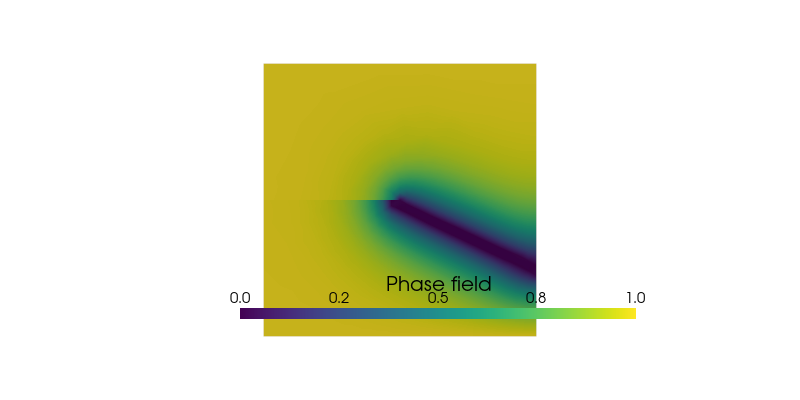

In [6]:
reader = pv.get_reader(f"{out_dir}/AT2_OrthoMasonry.pvd")

mesh = reader.read()[0]
pv.set_jupyter_backend("static")
p = pv.Plotter(shape=(1, 1), border=False)
p.add_mesh(
    mesh,
    scalars=pf,
    show_edges=False,
    show_scalar_bar=True,
    clim=clim,
    scalar_bar_args=sargs,
)

p.view_xy()
p.camera.zoom(1.0)
p.window_size = [800, 400]
p.show()

## Post-processing
Figures compares the load-deflection curve for both models. As soon as the crack starts to propagate, the load drops.

In [7]:
# define function to obtain displacement applied on the top end of the square plate
def displ_midpoint(filename):
    data = pv.read(filename)
    max_y = max(data.points[:, 1])
    return np.mean(
        data.point_data["displacement"][:, 0],
        where=np.transpose(data.points[:, 1] == max_y),
    )


# define function to obtain force acting on the on the top end of the square plate from vtu file


def force_midpoint(filename):
    data = pv.read(filename)
    max_y = max(data.points[:, 1])
    return np.sum(
        data.point_data["NodalForces"][:, 0],
        where=np.transpose(data.points[:, 1] == max_y),
    )


# define function applying above-mentioned functions on all vtu files listed in the correspondent pvd file,
# returning force-displacement curve


def force_displ_from_pvd(pvd):
    doc = minidom.parse(str(pvd))
    DataSets = doc.getElementsByTagName("DataSet")
    vtu_files = [x.getAttribute("file") for x in DataSets]
    forces_sum = [force_midpoint(f"{out_dir}/{x}") for x in vtu_files]
    displs_mean = [displ_midpoint(f"{out_dir}/{x}") for x in vtu_files]
    return [displs_mean, forces_sum]

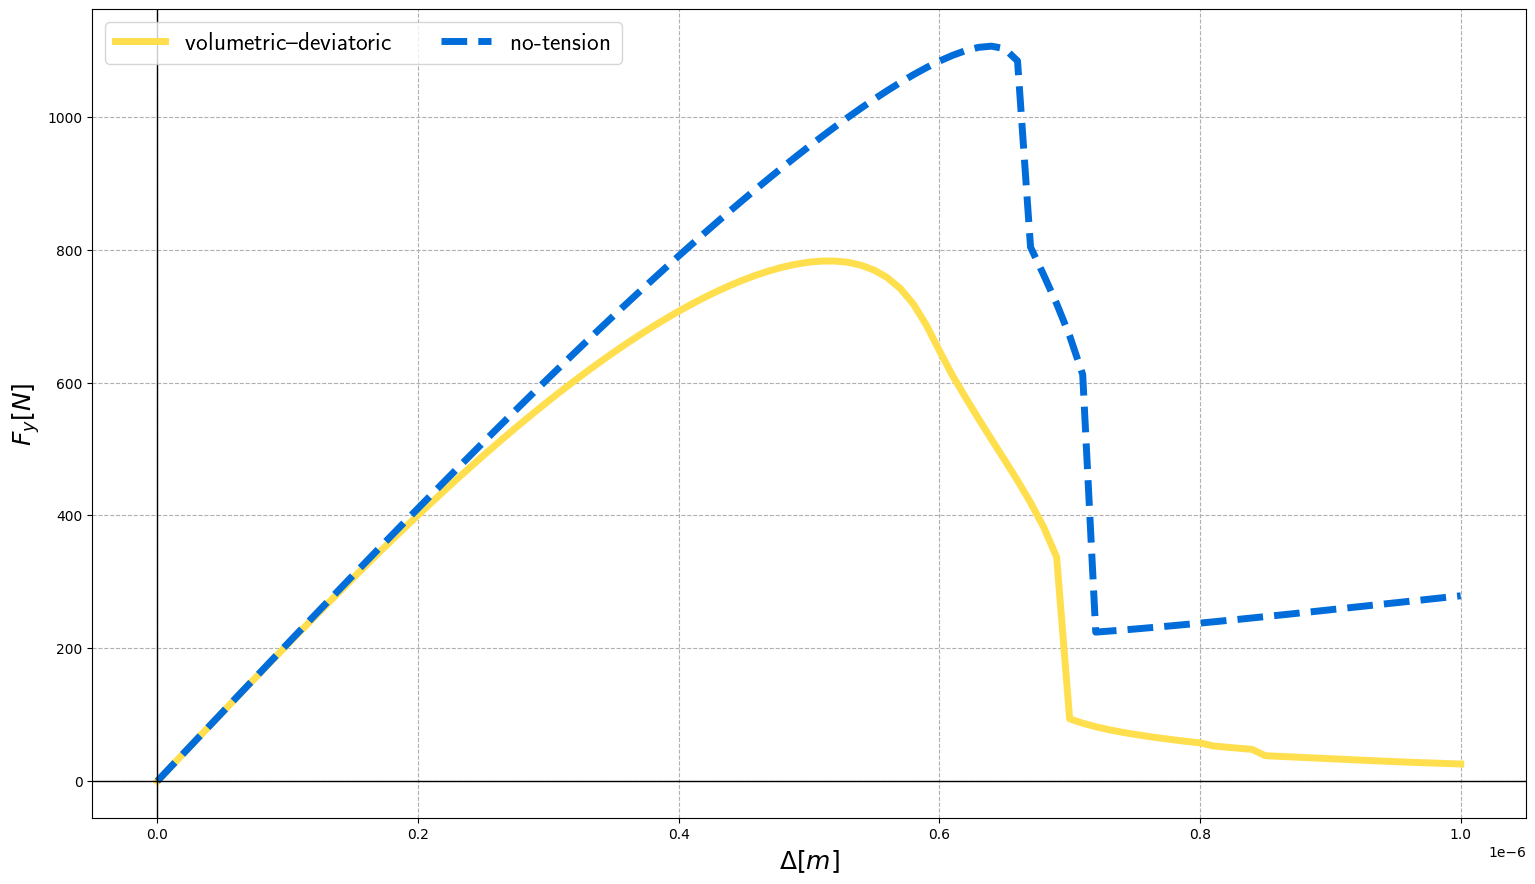

In [8]:
# AT2_OrthoVolDev.pvd
prefixes = ["AT2_OrthoVolDev", "AT2_OrthoMasonry"]
labels = [r"volumetric--deviatoric", r"no-tension"]
ls = ["-", "--"]
colors = ["#ffdf4d", "#006ddb"]

fig, ax = plt.subplots()
plt.rc("text", usetex=True)
fig.set_size_inches(18.5, 10.5)
for i, pre in enumerate(prefixes):
    pvd = out_dir / f"{pre}.pvd"
    if pvd.is_file():
        curve = force_displ_from_pvd(pvd)
        ax.plot(
            curve[0],
            curve[1],
            ls[i % 2],
            label=labels[i],
            linewidth=5,
            color=colors[i],
            alpha=1,
        )

plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
ax.grid(linestyle="dashed")
ax.set_xlabel(r"$\Delta [m]$", fontsize=18)
ax.set_ylabel("$F_y [N]$", fontsize=18)
plt.legend(fontsize=18, ncol=2)
ax.axhline(y=0, color="black", linewidth=1)
ax.axvline(x=0, color="black", linewidth=1)

## References
[1] Vahid Ziaei-Rad, Mostafa Mollaali, Thomas Nagel, Olaf Kolditz, Keita Yoshioka,
Orthogonal decomposition of anisotropic constitutive models for the phase field approach to fracture,
Journal of the Mechanics and Physics of Solids,
Volume 171,
2023,
105143.

[2] Hanen Amor, Jean-Jacques Marigo, Corrado Maurini,
Regularized formulation of the variational brittle fracture with unilateral contact: Numerical experiments,
Journal of the Mechanics and Physics of Solids,
Volume 57, Issue 8,
2009,
Pages 1209-1229.

[3] Francesco Freddi, Gianni Royer-Carfagni,
Regularized variational theories of fracture: A unified approach,
Journal of the Mechanics and Physics of Solids,
Volume 58, Issue 8,
2010,
Pages 1154-1174.